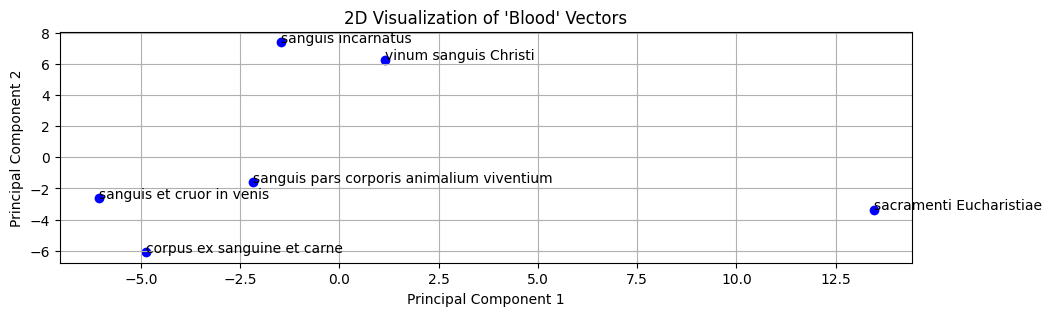

In [1]:
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

nlp = spacy.load("la_core_web_lg")

# Words to be visualized
words = ["sanguis pars corporis animalium viventium", "sanguis incarnatus", "sacramenti Eucharistiae", "sanguis et cruor in venis", "corpus ex sanguine et carne", "vinum sanguis Christi"]
vectors = [nlp(word).vector for word in words]

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
vectors_reduced = pca.fit_transform(vectors)

# Visualization of the vectors
plt.figure(figsize=(11, 3))
for i, word in enumerate(words):
    if word in ["non", "aut"]:
        plt.scatter(vectors_reduced[i, 0], vectors_reduced[i, 1], color='pink')
        plt.annotate(word, xy=(vectors_reduced[i, 0], vectors_reduced[i, 1]), color='pink')
    else:
        plt.scatter(vectors_reduced[i, 0], vectors_reduced[i, 1], color='blue')
        plt.annotate(word, xy=(vectors_reduced[i, 0], vectors_reduced[i, 1]), color='black')

plt.title("2D Visualization of 'Blood' Vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


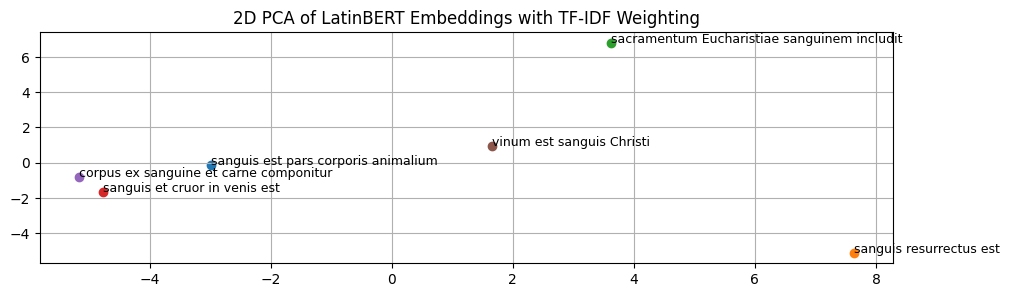

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel, RobertaTokenizer
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Modell und Tokenizer laden
path_to_latin_bert = "./bert-base-latin-uncased/"

tokenizer = AutoTokenizer.from_pretrained(path_to_latin_bert)
model = AutoModel.from_pretrained(path_to_latin_bert)

# Lateinische Phrasen
phrases = [
    "sanguis est pars corporis animalium",
    "sanguis resurrectus est",
    "sacramentum Eucharistiae sanguinem includit",
    "sanguis et cruor in venis est",
    "corpus ex sanguine et carne componitur",
    "vinum est sanguis Christi"
]

# TF-IDF Berechnung
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(phrases)
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Embedding für jedes Wort extrahieren
def get_word_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

word_embeddings = {word: get_word_embeddings(word) for word in feature_names}

# TF-IDF-gewichtete Summe der Embeddings für jede Phrase
def get_tfidf_weighted_embedding(tfidf_scores, embeddings, words):
    weighted_embeddings = np.zeros((embeddings[list(embeddings.keys())[0]].shape[0],))
    for word, score in zip(words, tfidf_scores):
        weighted_embeddings += embeddings[word] * score
    return weighted_embeddings

embeddings = np.array([get_tfidf_weighted_embedding(scores, word_embeddings, feature_names) for scores in tfidf_scores])

# PCA Anwendung zur Reduktion auf 2 Dimensionen
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualisierung der Punkte
plt.figure(figsize=(11, 3))
for i, phrase in enumerate(phrases):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.annotate(phrase, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)
plt.title('2D PCA of LatinBERT Embeddings with TF-IDF Weighting')

plt.grid(True)
plt.show()
